In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python3 --version

Python 3.10.11


# Library

In [ ]:
# !pip install catboost
# !pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re
#machine learning
from sklearn.linear_model import Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# import optuna
# from catboost import CatBoostRegressor

# Dataset

In [ ]:
#데이터셋
train = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_train.csv")
test = pd.read_csv("/content/drive/MyDrive/Weather/data/surface_tp_test.csv")

train.drop(['Unnamed: 0'],1,inplace=True)
test.drop(['Unnamed: 0'],1,inplace=True)

#검증 데이터셋
ss_spring = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="SPRING")
ss_summer = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="SUMMER")
ss_autumn = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="AUTUMN")
ss_winter = pd.read_excel("/content/drive/MyDrive/Weather/data/subminssionUser.xlsx",sheet_name="WINTER")

# Description

- stn : 지점번호
- year : 년도
- ta : 1시간 평균 기온(C)
- td : 1시간 평균 이슬점온도(C)
- hm : 1시간 평균 상대습도(%)
- ws : 1시간 평균 풍속(m/s)
- si : 1시간 누적 일사량(MJ)
- ss : 1시간 누적 일조량(시간)
- rn : 1시간 누적 강수량(mm)
- sn : MMDDHH 중 HH시 00분에 측정된 적설 깊이(cm)
- re : 1시간 누적 강수유무(분)
- ww : 현천계 현천
    - S : 눈
    - R : 비
    - H : 박무
    - G : 연무
    - C : 맑음
    - X : 모름
- **ts : 1시간 평균 지면온도(C)**

# Data Wrangling

In [ ]:
print(train.columns)
print(test.columns)

Index(['surface_tp_train.stn', 'surface_tp_train.year',
       'surface_tp_train.mmddhh', 'surface_tp_train.ta', 'surface_tp_train.td',
       'surface_tp_train.hm', 'surface_tp_train.ws', 'surface_tp_train.rn',
       'surface_tp_train.re', 'surface_tp_train.ww', 'surface_tp_train.ts',
       'surface_tp_train.si', 'surface_tp_train.ss', 'surface_tp_train.sn'],
      dtype='object')
Index(['surface_tp_test.stn', 'surface_tp_test.year', 'surface_tp_test.mmddhh',
       'surface_tp_test.ta', 'surface_tp_test.td', 'surface_tp_test.hm',
       'surface_tp_test.ws', 'surface_tp_test.rn', 'surface_tp_test.re',
       'surface_tp_test.ww', 'surface_tp_test.si', 'surface_tp_test.ss',
       'surface_tp_test.sn'],
      dtype='object')


**Obseravation**

- train set과 test set 변수명이 달라서 전처리 필요
- surface_tp_ts가 target

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438240 entries, 0 to 438239
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   surface_tp_train.stn     438240 non-null  int64  
 1   surface_tp_train.year    438240 non-null  object 
 2   surface_tp_train.mmddhh  438240 non-null  int64  
 3   surface_tp_train.ta      438240 non-null  float64
 4   surface_tp_train.td      438240 non-null  float64
 5   surface_tp_train.hm      438240 non-null  float64
 6   surface_tp_train.ws      438240 non-null  float64
 7   surface_tp_train.rn      438240 non-null  float64
 8   surface_tp_train.re      438240 non-null  int64  
 9   surface_tp_train.ww      438240 non-null  object 
 10  surface_tp_train.ts      438240 non-null  float64
 11  surface_tp_train.si      438240 non-null  float64
 12  surface_tp_train.ss      438240 non-null  float64
 13  surface_tp_train.sn      438240 non-null  float64
dtypes: f

In [ ]:
train.shape, test.shape

((438240, 14), (26280, 13))

In [ ]:
train.isnull().sum()

surface_tp_train.stn       0
surface_tp_train.year      0
surface_tp_train.mmddhh    0
surface_tp_train.ta        0
surface_tp_train.td        0
surface_tp_train.hm        0
surface_tp_train.ws        0
surface_tp_train.rn        0
surface_tp_train.re        0
surface_tp_train.ww        0
surface_tp_train.ts        0
surface_tp_train.si        0
surface_tp_train.ss        0
surface_tp_train.sn        0
dtype: int64

In [ ]:
train.describe()

,surface_tp_train.stn,surface_tp_train.mmddhh,surface_tp_train.ta,surface_tp_train.td,surface_tp_train.hm,surface_tp_train.ws,surface_tp_train.rn,surface_tp_train.re,surface_tp_train.ts,surface_tp_train.si,surface_tp_train.ss,surface_tp_train.sn
count,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000,438240.000000
mean,5.500000,66819.769441,13.648830,6.546744,65.429143,1.982703,-1.539624,2.608285,15.268847,-45.005243,-45.094056,-98.205804
std,2.872285,34506.091290,11.042725,12.627285,22.430588,5.156003,12.996733,13.570768,13.362203,50.307733,50.000381,13.128373
min,1.000000,10100.000000,-99.900000,-99.900000,-99.900000,-99.900000,-99.900000,-99.000000,-99.900000,-99.900000,-99.900000,-99.900000
25%,3.000000,40202.000000,5.800000,-2.400000,49.200000,1.000000,0.000000,0.000000,4.800000,-99.900000,-99.900000,-99.900000
50%,5.500000,70209.000000,14.700000,7.300000,66.500000,1.800000,0.000000,0.000000,15.500000,0.010000,0.000000,-99.900000
75%,8.000000,100116.000000,22.200000,17.100000,83.900000,3.000000,0.000000,0.000000,24.300000,0.990000,0.700000,-99.900000
max,10.000000,123123.000000,39.400000,29.300000,100.000000,24.600000,623.500000,60.000000,65.700000,4.770000,1.000000,37.400000


**Observation**

- stn : 10개의 지점에서 측정이 됨
- mmddhh : 10월 10일 00시가 최솟값이고 12월 31일 23시가 최댓값
- 이 외의 다른 변수들에는 이상치가 존재 (-99)

# Preprocessing

In [ ]:
#변수명 변경
train.columns = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','ts','si','ss','sn']
test.columns  = ['stn','year','mmddhh','ta','td','hm','ws','rn','re','ww','si','ss','sn']

#타입 변경
train['stn'] = train['stn'].astype("object")
test['stn'] = test['stn'].astype("object")

#mmddhh feature engineering
train['mmddhh'] = train['mmddhh'].astype(str)

train['month'] = train['mmddhh'].apply(lambda x: x[:2] if len(x) > 5 else x[:1])
train['day'] = train['mmddhh'].str.slice(2,4)
train['hour'] = train['mmddhh'].str.slice(4,6)

test['mmddhh'] = test['mmddhh'].astype(str)
test['month'] = test['mmddhh'].apply(lambda x: x[:2] if len(x) > 5 else x[:1])
test['day'] = test['mmddhh'].str.slice(2,4)
test['hour'] = test['mmddhh'].str.slice(4,6)

#수치형 변수로 변환
def astyp(data,column):
  for _ in column:
    data[_] = data[_].astype('int32')

astyp(train, ['mmddhh'])
astyp(test, ['mmddhh'])

#rare labels
train['ww']=train['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)
test['ww']=test['ww'].apply(lambda x: 'Else' if x in ['F','S','X'] else x)

#diff features
train['diff'] = train['ta'].diff()
test['diff'] = test['ta'].diff()

#shift
train['shift_1']=train['ta'].shift(1)
test['shift_1']=test['ta'].shift(1)

#이동평균선
train['rolling'] = train['ta'].rolling(window=7).mean()
test['rolling'] = test['ta'].rolling(window=7).mean()

#확장이동
train['expanding'] = train['ta'].expanding(min_periods=7).mean()
test['expanding'] = test['ta'].expanding(min_periods=7).mean()

# EDA

In [ ]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = train.select_dtypes(exclude=['object']).columns.tolist()

In [ ]:
pd.DataFrame(train.groupby(['year','month'])['ts'].mean())

In [ ]:
def show_countplot(df, columns):
    i = 0
    plt.figure()
    plt.subplots(2,3,figsize=(18,8))
    for col in columns:
        i += 1
        plt.subplot(2,3,i)
        plt.xticks(rotation=45)
        sns.countplot(x=df[col])
    plt.tight_layout()

def show_distplot(df, columns):
    i = 0
    plt.figure()
    plt.subplots(3,5,figsize=(18,8))
    for col in columns:
        i += 1
        plt.subplot(3,5,i)
        sns.kdeplot(df[col],shade=True)
    plt.tight_layout()


def show_barplot(df, columns):
    i = 0
    plt.figure()
    plt.subplots(2,3,figsize=(18,8))
    for col in columns:
        i += 1
        plt.subplot(2,3,i)
        sns.barplot(x=df[col], y=df['ts'])
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

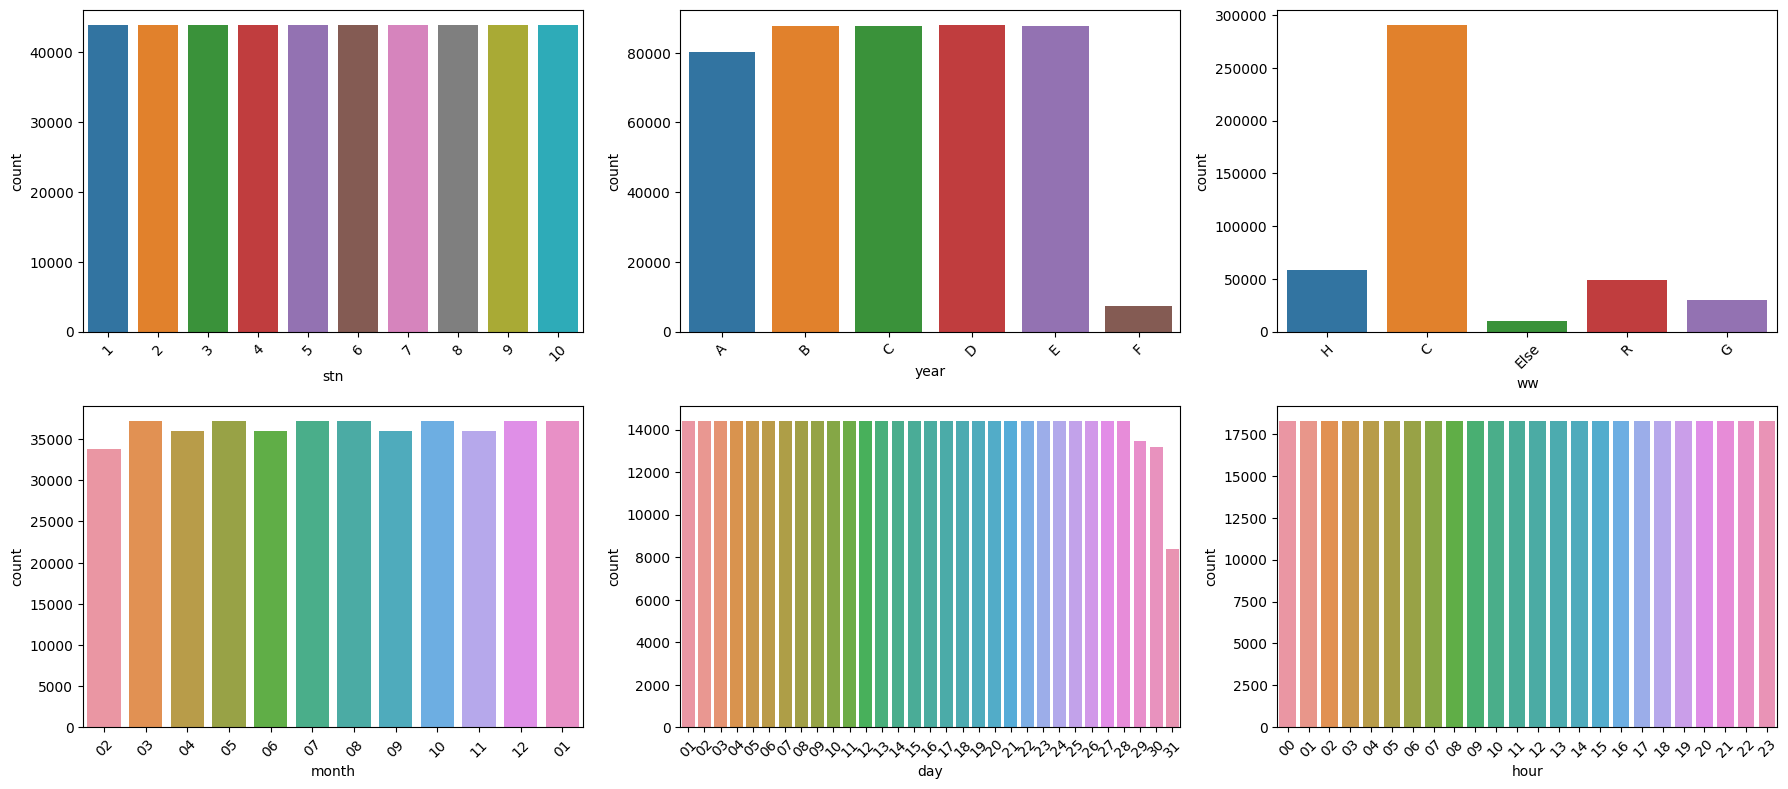

In [ ]:
#countplot
show_countplot(train, cat_cols)

<Figure size 640x480 with 0 Axes>

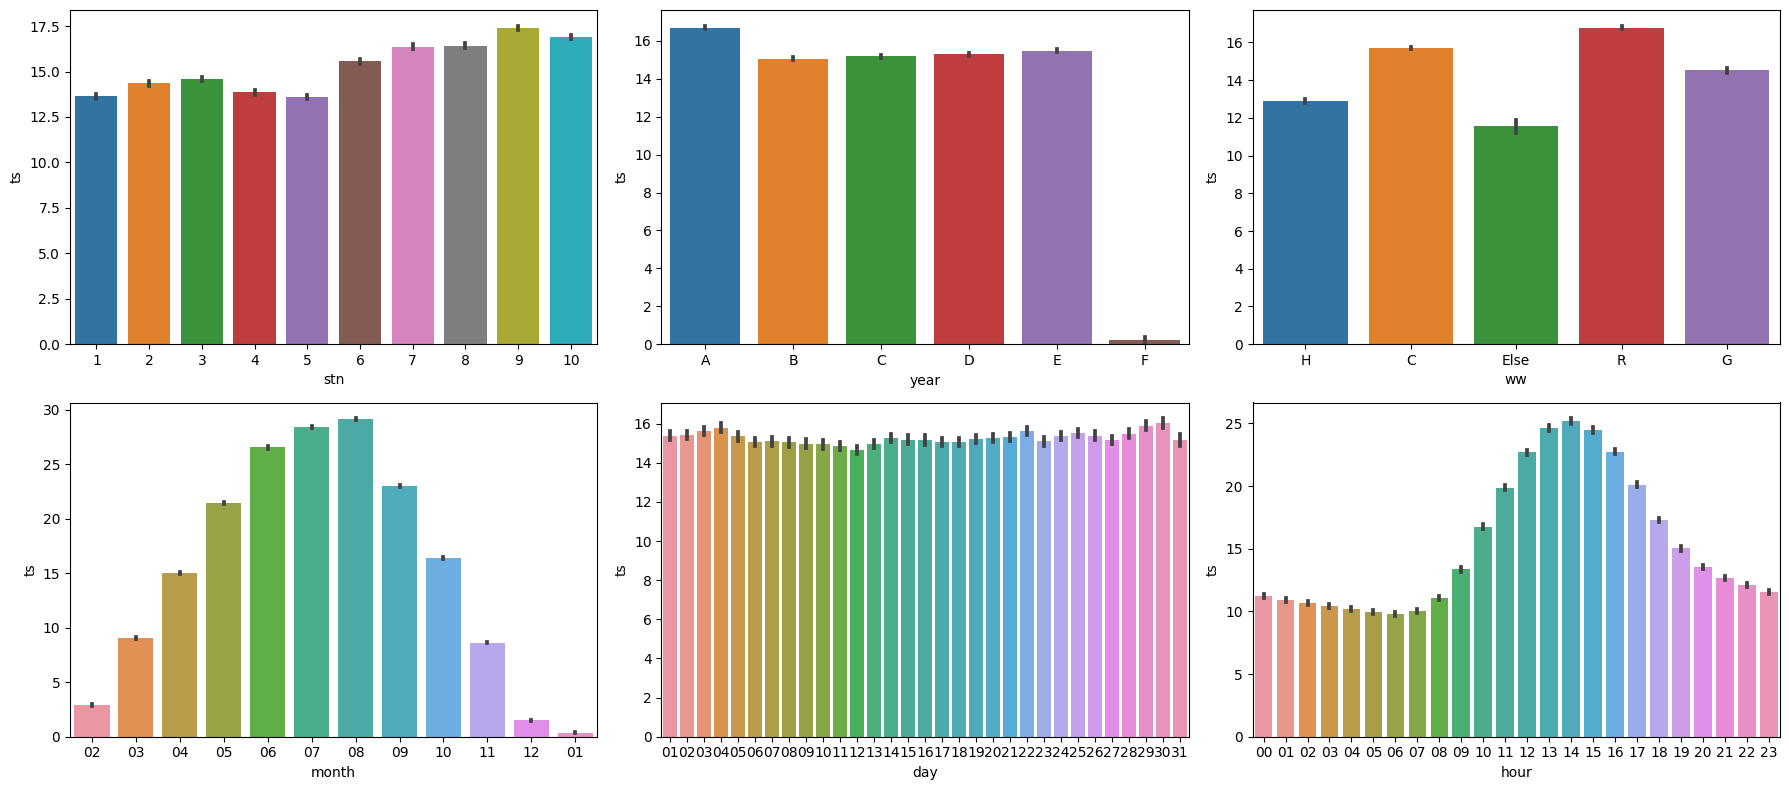

In [ ]:
#barplot
show_barplot(train, cat_cols)

**Observation**

- `ww` 변수 rare Label들을 하나로 묶는 건 어떨까

In [ ]:
train['ww'].value_counts()

C    290265
H     58793
R     49177
G     30100
X      3514
F      3499
S      2892
Name: ww, dtype: int64

<Axes: xlabel='ww', ylabel='ts'>

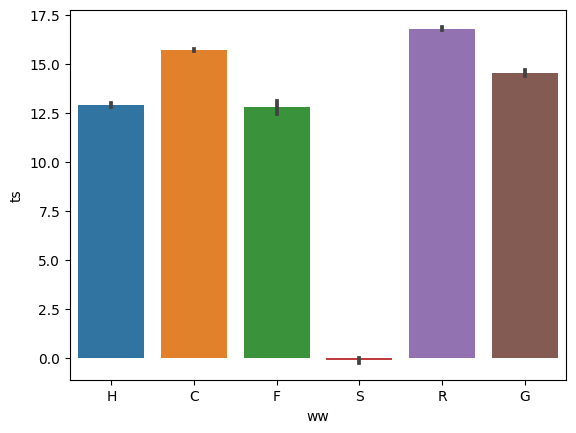

In [ ]:
sns.barplot(data=train, x='ww', y='ts')

<Figure size 640x480 with 0 Axes>

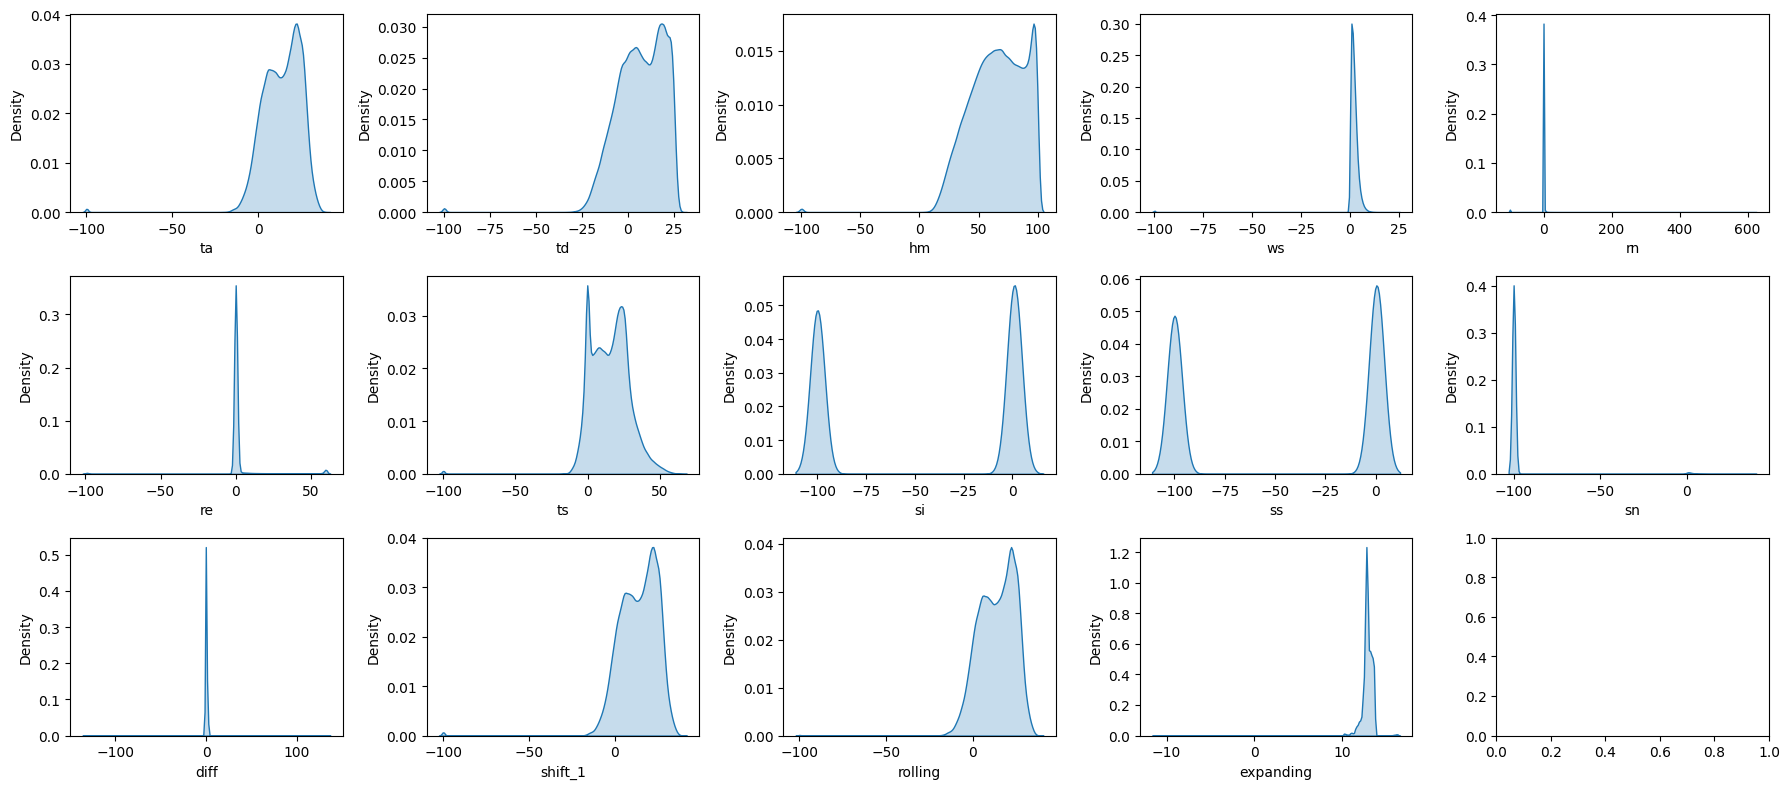

In [ ]:
show_distplot(train, num_cols)

**Observation**

- target 예측에 도움이 되지 않는 변수가 존재

## -99.9의 값을 가지는 비율 확인

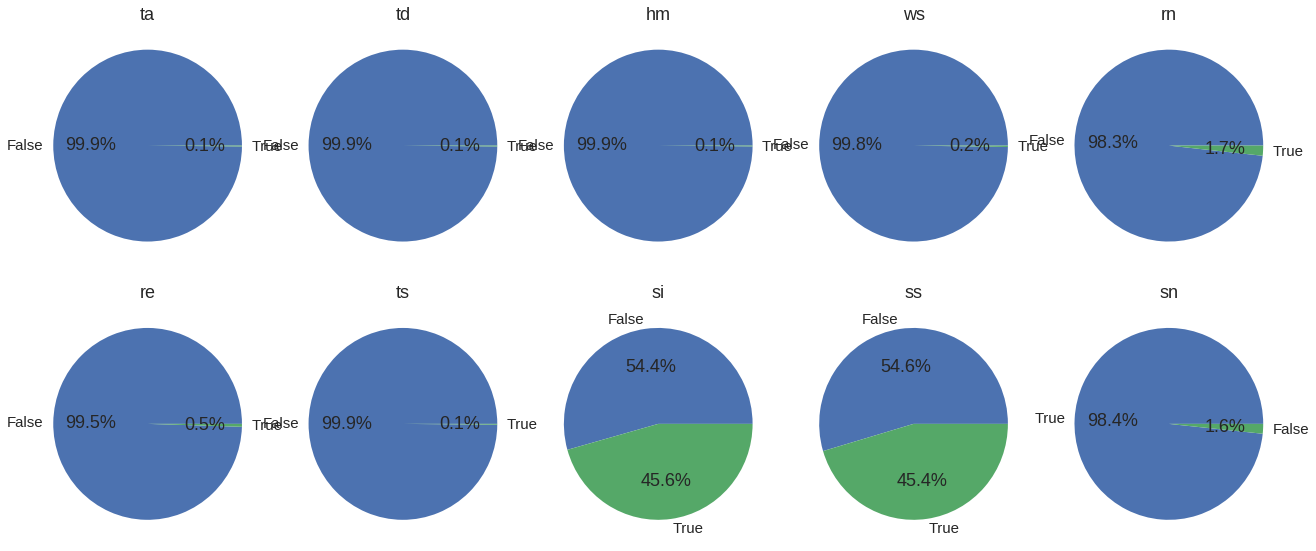

In [ ]:
plt.figure()
plt.subplots(2,5,figsize=(18,8))
i = 0
for col in num_cols:
    i += 1
    plt.subplot(2,5,i)
    plt.title(f'{col}')
    null_data = ((train[col] == -99.9) | (train[col] == -99)).value_counts()
    plt.pie(null_data.values, labels=null_data.index, autopct="%.1f%%")
plt.tight_layout()

**Observation**

- sn 변수를 drop
- si, ss를 어떻게 처리할 것인가?

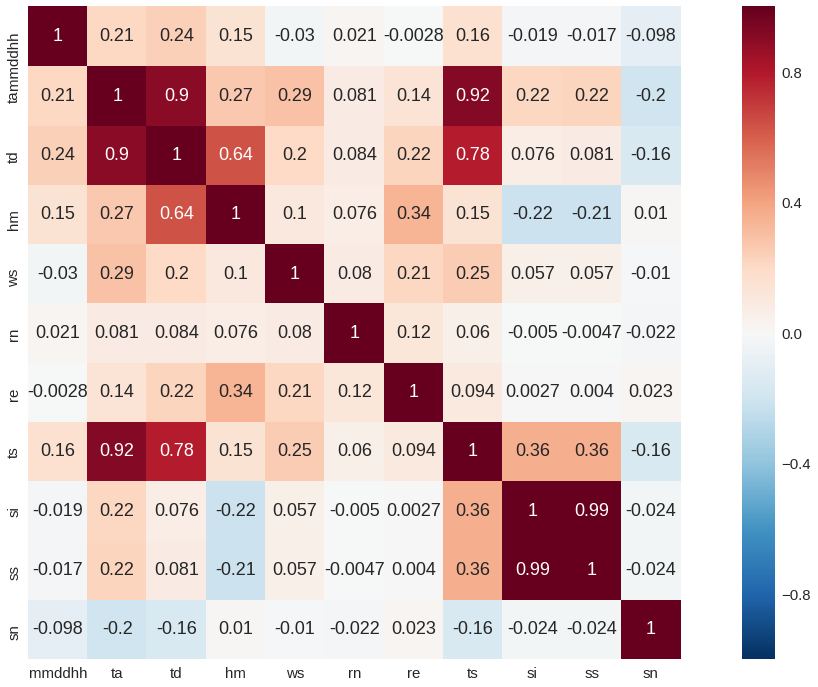

In [ ]:
sns.set(font_scale=1.5)
plt.figure(figsize=(22,12))
sns.heatmap(train.corr(), annot=True, square=True)

**Observation**

- target과 양의 선형관계를 가지는 변수는 순서대로 ta, td, si,ss 순이다.
- [ta,td], [si, ss] 다중공선성 의심됨

# Post-Processing

<Axes: xlabel='ta', ylabel='ts'>

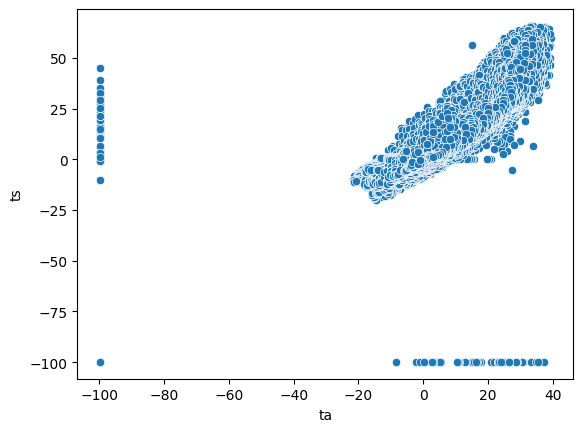

In [ ]:
sns.scatterplot(x=train['ta'], y=train['ts'])

In [ ]:
train = train.drop(train[(train['ta'] < -80) | (train['ts'] < -80)].index)

<Axes: xlabel='ta', ylabel='ts'>

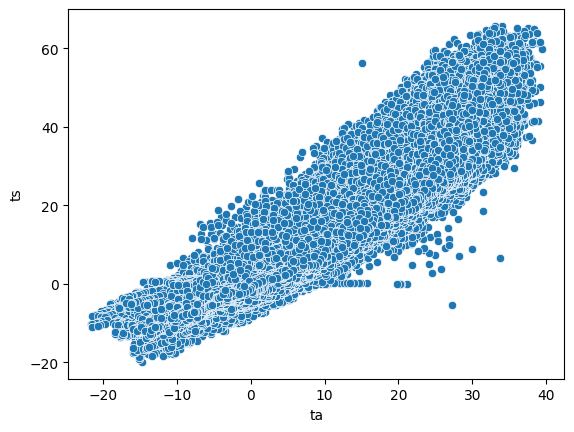

In [ ]:
sns.scatterplot(x=train['ta'], y=train['ts'])